### Text Preprocessing
La préparation de textes se fera de différentes façons en fonction de la représentation du texte. Tout d'abord, on fait un nettoyage basique : suppression des sauts de ligne et des espaces multiples.
- sac de mots / TFIDF / Ngrammes: mise en minuscule, suppression de la ponctuation, tokenisation, suppression des stopwords, lemmatisation
- Word2Vec : idem mais sans la suppression des stopwords pour garder la sémantique de la phrase

In [1]:
import re

def nettoyage_basique(texte):
    # remplacement des sauts de ligne par un espace
    texte = re.sub(r'\n+', ' ', texte)

    # suppression des espaces multiples
    texte = re.sub(r'\s+', ' ', texte).strip()
    
    return texte

Text preprocessing des sacs de mots et TFIDF

In [2]:
import spacy

# charger le modèle anglais
nlp = spacy.load("en_core_web_sm")

def preprocessing_bow_tfidf(text):
    # nettoyage minimal du texte et mise en minuscules
    text = nettoyage_basique(text.lower())

    # tokenisation
    tokens = nlp(text)

    # token.lemma_ -> lemmatisation, token.is_stop -> stopwords, token.is_punct -> ponctuation
    clean_tokens = [t.lemma_ for t in tokens 
                    if not t.is_stop and not t.is_punct]

    return ' '.join(clean_tokens)

Text preprocessing Word2Vec

In [3]:
def preprocessing_word2vec(text):
    # nettoyage minimal du texte et mise en minuscules
    text = nettoyage_basique(text.lower())

    # tokenisation
    tokens = nlp(text)
    
    # token.lemma_ -> lemmatisation, token.is_punct -> ponctuation
    clean_tokens = [t.lemma_ for t in tokens if not t.is_punct]

    return clean_tokens

### Modèles de machine learning
#### Chargement des données

In [ ]:
import json
import random as rd
import numpy as np
from sklearn.model_selection import train_test_split

# Charger les reviews
reviews = []
with open('review.jsonl', 'r', encoding='utf-8') as file:
    for line in file:
        reviews.append(json.loads(line))

# prendre 20 000 lignes au hasard
sampled_reviews = rd.sample(reviews, 20000)

# Extraire les textes et notes
texts = [r["text"] for r in sampled_reviews]
ratings = np.array([r["stars"] for r in sampled_reviews])

X_train, X_test, y_train, y_test = train_test_split(
    texts, ratings, test_size=0.2, random_state=42
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 16000, Test: 4000


#### Dictionnaire pour stocker tous les résultats

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def stockage_resultats(dict, model, y_pred):
    dict['accuracy'][model] = accuracy_score(y_test, y_pred)
    dict['precision'][model] = precision_score(y_test, y_pred, average='weighted')
    dict['recall'][model] = recall_score(y_test, y_pred, average='weighted')
    dict['f1-score'][model] = f1_score(y_test, y_pred, average='weighted')

bow = {'accuracy': {}, 'precision': {}, 'recall': {}, 'f1-score': {}}
tfidf = {'accuracy': {}, 'precision': {}, 'recall': {}, 'f1-score': {}}
ngram = {'accuracy': {}, 'precision': {}, 'recall': {}, 'f1-score': {}}
word2vec = {'accuracy': {}, 'precision': {}, 'recall': {}, 'f1-score': {}}

#### Prédiction du score à partir d'un avis
Pour chaque représentation de textes, on utilisera les modèles de classification suivants : SVM linéaire et régression logistique.
##### Sac de mots / Bag of words (BoW)

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

print("BAG OF WORDS")

# Vectorisation BOW
bow_vectorizer = CountVectorizer(
    max_features=5000, # number of words stored in vectors
    preprocessor=preprocessing_bow_tfidf, # personnal text preprocessing function
    tokenizer=None # because we have already tokenised the text in our function
)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# régression logistique
lr_bow = LogisticRegression(max_iter=1000, n_jobs=-1) # création du modèle
lr_bow.fit(X_train_bow, y_train) # entrainement du modèle
lr_y_pred_bow = lr_bow.predict(X_test_bow) # prédiction sur les données de test
stockage_resultats(bow, 'lr', lr_y_pred_bow)
print("Entrainement modèle de régression logistique terminé")

# SVM Linéaire
svm_bow = LinearSVC(max_iter=3000) # création du modèle
svm_bow.fit(X_train_bow, y_train) # entrainement du modèle
svm_y_pred_bow = svm_bow.predict(X_test_bow) # prédiction sur les données de test
stockage_resultats(bow, 'svm', svm_y_pred_bow)
print("Entrainement modèle SVM terminé")

BAG OF WORDS
Entrainement modèle de régression logistique terminé
Entrainement modèle SVM terminé


##### Ngram

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("NGRAM")

# Vectorisation TF-IDF
ngram_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=5000,
    preprocessor=preprocessing_bow_tfidf,
    tokenizer=None
)
X_train_ngram = ngram_vectorizer.fit_transform(X_train)
X_test_ngram = ngram_vectorizer.transform(X_test)

# régression logistique
lr_ngram = LogisticRegression(max_iter=1000, n_jobs=-1)
lr_ngram.fit(X_train_ngram, y_train)
lr_y_pred_ngram = lr_ngram.predict(X_test_ngram)
stockage_resultats(ngram, 'lr', lr_y_pred_ngram)
print("Entrainement modèle de régression logistique terminé")

# SVM Linéaire
svm_ngram = LinearSVC(max_iter=3000)
svm_ngram.fit(X_train_ngram, y_train)
svm_y_pred_ngram = svm_ngram.predict(X_test_ngram)
stockage_resultats(ngram, 'svm', svm_y_pred_ngram)
print("Entrainement modèle SVM terminé")

NGRAM
Entrainement modèle de régression logistique terminé
Entrainement modèle SVM terminé


##### TF-IDF

In [8]:
print("TF-IDF")

# Vectorisation TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    preprocessor=preprocessing_bow_tfidf,
    tokenizer=None
)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# régression logistique
lr_tfidf = LogisticRegression(max_iter=1000, n_jobs=-1)
lr_tfidf.fit(X_train_tfidf, y_train)
lr_y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)
stockage_resultats(tfidf, 'lr', lr_y_pred_tfidf)
print("Entrainement modèle de régression logistique terminé")

# SVM Linéaire
svm_tfidf = LinearSVC(max_iter=3000)
svm_tfidf.fit(X_train_tfidf, y_train)
svm_y_pred_tfidf = svm_tfidf.predict(X_test_tfidf)
stockage_resultats(tfidf, 'svm', svm_y_pred_tfidf)
print("Entrainement modèle SVM terminé")

TF-IDF
Entrainement modèle de régression logistique terminé
Entrainement modèle SVM terminé


##### Word2Vec

In [9]:
from gensim.models import Word2Vec

print("WORD2VEC")

# préparation du texte pour word2vec
tokenized_train = [preprocessing_word2vec(text) for text in X_train]
tokenized_test = [preprocessing_word2vec(text) for text in X_test]

# Entraînement Word2Vec
w2v_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=2, workers=4)

def document_vector(tokens, w2v_model, vector_size=100):
    """Calcule la moyenne des vecteurs des mots du document"""
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

# Transformation des textes en vecteurs
X_train_w2v = np.array([document_vector(tokens, w2v_model) for tokens in tokenized_train])
X_test_w2v = np.array([document_vector(tokens, w2v_model) for tokens in tokenized_test])

print(f"Shape X_train: {X_train_w2v.shape}")

# régression logistique
lr_w2v = LogisticRegression(max_iter=1000, n_jobs=-1)
lr_w2v.fit(X_train_w2v, y_train)
lr_y_pred_w2v = lr_w2v.predict(X_test_w2v)
stockage_resultats(word2vec, 'lr', lr_y_pred_w2v)
print("Entrainement modèle de régression logistique terminé")

# linear svc
svm_w2v = LinearSVC(max_iter=3000)
svm_w2v.fit(X_train_w2v, y_train)
svm_y_pred_w2v = svm_w2v.predict(X_test_w2v)
stockage_resultats(word2vec, 'svm', svm_y_pred_w2v)
print("Entrainement modèle SVM terminé")

WORD2VEC
Shape X_train: (16000, 100)
Entrainement modèle de régression logistique terminé
Entrainement modèle SVM terminé


#### Evaluation des modèles de classification

In [10]:
import pandas as pd

# performance des modèles avec sac de mots
df_bow = pd.DataFrame(bow).round(4)
print("\n" + "="*50)
print("PERFORMANCES BOW")
print("="*50)
print(df_bow)

# performance des modèles avec tfidf
df_tfidf = pd.DataFrame(tfidf).round(4)
print("\n" + "="*50)
print("PERFORMANCES TFIDF")
print("="*50)
print(df_tfidf)

# performance des modèles avec ngram
df_ngram = pd.DataFrame(ngram).round(4)
print("\n" + "="*50)
print("PERFORMANCES NGRAM")
print("="*50)
print(df_ngram)

# performance des modèles avec word2vec
df_word2vec = pd.DataFrame(word2vec).round(4)
print("\n" + "="*50)
print("PERFORMANCES WORD2VEC")
print("="*50)
print(df_word2vec)


PERFORMANCES BOW
     accuracy  precision  recall  f1-score
lr     0.6128     0.5955  0.6128    0.6025
svm    0.5728     0.5654  0.5728    0.5683

PERFORMANCES TFIDF
     accuracy  precision  recall  f1-score
lr     0.6445     0.6040  0.6445    0.6117
svm    0.6218     0.5901  0.6218    0.6009

PERFORMANCES NGRAM
     accuracy  precision  recall  f1-score
lr     0.6485     0.6093  0.6485    0.6156
svm    0.6185     0.5895  0.6185    0.5995

PERFORMANCES WORD2VEC
     accuracy  precision  recall  f1-score
lr     0.6225     0.5832  0.6225    0.5905
svm    0.6215     0.5767  0.6215    0.5635


#### Matrice de confusion du meilleur modèle

[2 5 3 4 2]


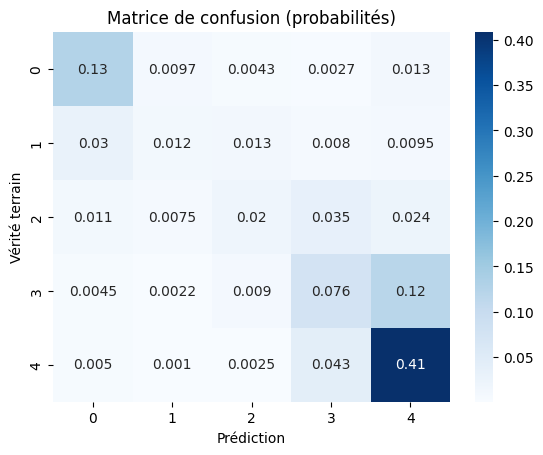

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, lr_y_pred_tfidf)
print(lr_y_pred_tfidf[:5])
# Convertir les comptes en probabilités
cm_proba = cm.astype('float') / cm.sum()

# Créer une heatmap avec les probabilités
sns.heatmap(cm_proba, annot=True, fmt='.2', cmap='Blues', 
            xticklabels=['1', '2', '3', '4', '5'], 
            yticklabels=['1', '2', '3', '4', '5'])
plt.title('Matrice de confusion (probabilités)')
plt.ylabel('Vérité terrain')
plt.xlabel('Prédiction')
plt.show()